In [13]:
import numpy as np
import uproot 
from sklearn.model_selection import KFold

training_features=[
        "vtx_prob",
        "mu1_pfreliso03",
        "mu2_pfreliso03",
        "FlightDistBS_SV_Significance",
        "mu1_bs_dxy_sig",
        "mu2_bs_dxy_sig",
        "mu3_bs_dxy_sig",
        "mu4_bs_dxy_sig",
        "Cos2d_BS_SV",
        "Quadruplet_Eta",
        "Quadruplet_Pt",
        "RefittedSV_Mass_reso"#,
#    "bdt_cv"
    ]
# --- Dati ---
bkgdf = uproot.open("/lustrehome/mbuonsante/B_4mu/CMSSW_13_0_13/src/Analysis/FinalFiles_B4mu_09_12_25/Analyzed_Data_B4mu_os_bdt.root")["FinalTree"].arrays(library="pd")
sigdf = uproot.open("/lustrehome/mbuonsante/B_4mu/CMSSW_13_0_13/src/Utilities_organized/ROOTFiles_20_01_25/AllData_rw_bdt_v0.root")["FinalTree"].arrays(library="pd")
bkgdf = bkgdf[bkgdf["RefittedSV_Mass_reso"]>0]
bkgdf = bkgdf[bkgdf["RefittedSV_Mass_reso"]<0.16]
bkgdf = bkgdf.reset_index(drop=True)
bkgdf = bkgdf[training_features]

sigdf = sigdf[sigdf["isMC"]==0]
sigdf["isMC"] = 1
mask = sigdf.eval("(RefittedSV_Mass>5.566) | (RefittedSV_Mass<5.079) & RefittedSV_Mass_reso>0 & RefittedSV_Mass_reso<0.16")
sigdf = sigdf[mask].reset_index(drop=True)
sigdf = sigdf[training_features]


In [14]:
sigdf_np = sigdf.to_numpy().astype(np.float32)
bkgdf_np = bkgdf.to_numpy().astype(np.float32)

In [16]:
import xgboost as xgb

X = np.concatenate([sigdf_np, bkgdf_np], axis=0)

y = np.concatenate([
    np.ones(len(sigdf_np), dtype=np.int32),  # A
    np.zeros(len(bkgdf_np), dtype=np.int32)    # B
])

# pesi opzionali per bilanciare le classi
w = np.concatenate([
    np.ones(len(sigdf_np)) / len(sigdf_np),
    np.ones(len(bkgdf_np)) / len(bkgdf_np)
])

In [17]:
dtrain = xgb.DMatrix(
    X,
    label=y
)

In [18]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",

    # GPU
    "tree_method": "hist",
    "device": "cuda",

    # regolarizzazione (molto importante)
    "max_depth": 3,
    "eta": 0.05,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "min_child_weight": 5,

    "seed": 42
}

In [19]:
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=300
)

In [20]:
#bst.save_model("xgb_model.bin")

In [21]:
dbkg = xgb.DMatrix(bkgdf_np)

pA = bst.predict(dbkg)    
pB = 1.0 - pA   

# peso di reweighting
weights = pA / pB

wmax = 10.0
weights = np.clip(weights, 0.0, wmax)

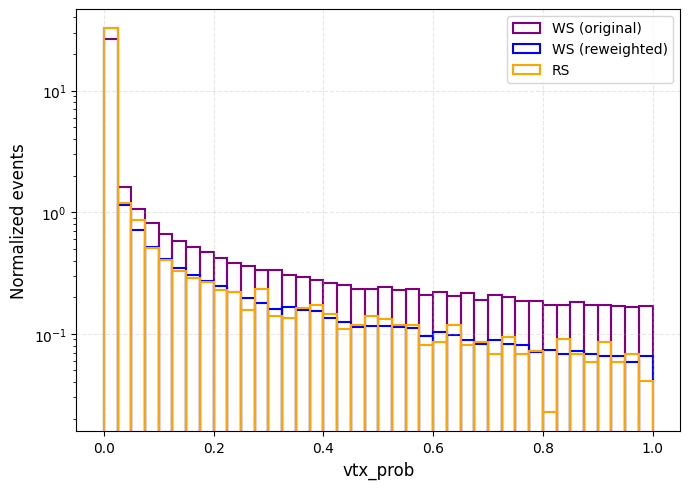

In [31]:
from matplotlib import pyplot as plt

feature_index = 0

plt.figure(figsize=(7,5))

# Range comune per tutti gli histogrammi
min_ = min(bkgdf_np[:, feature_index].min(), sigdf_np[:, feature_index].min())
max_ = max(bkgdf_np[:, feature_index].max(), sigdf_np[:, feature_index].max())

bins = 40

# Istogramma WS originale
plt.hist(
    bkgdf_np[:, feature_index],
    bins=bins,
    range=(min_, max_),
    label='WS (original)',
    edgecolor='purple',
    facecolor='none',
    linewidth=1.5,
    density=True
)

# Istogramma WS ripesato
plt.hist(
    bkgdf_np[:, feature_index],
    bins=bins,
    range=(min_, max_),
    weights=weights,
    label='WS (reweighted)',
    edgecolor='blue',
    facecolor='none',
    linewidth=1.5,
    density=True
)

# Istogramma RS
plt.hist(
    sigdf_np[:, feature_index],
    bins=bins,
    range=(min_, max_),
    label='RS',
    edgecolor='orange',
    facecolor='none',
    linewidth=1.5,
    density=True
)

plt.yscale('log')
plt.xlabel(training_features[feature_index], fontsize=12)
plt.ylabel('Normalized events', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
def weighted_corrcoef_df(df, weights):
    """
    Calcola la matrice di correlazione pesata per un DataFrame Pandas.

    df: DataFrame con shape (N, n_features)
    weights: array di pesi di shape (N,)
    """
    X = df.to_numpy()
    
    # media pesata
    mean = np.average(X, axis=0, weights=weights)
    
    # centro le variabili
    X_centered = X - mean
    
    # covariance pesata
    cov = np.cov(X_centered.T, aweights=weights, bias=True)
    
    # correlation matrix
    diag = np.sqrt(np.diag(cov))
    corr = cov / np.outer(diag, diag)
    
    # trasformo in DataFrame con nomi colonne
    corr_df = pd.DataFrame(corr, index=df.columns, columns=df.columns)
    
    return corr_df

corr_matrix_bkg = weighted_corrcoef_df(bkgdf, weights)
corr_matrix_sig = weighted_corrcoef_df(sigdf, None)


In [ ]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix_bkg, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Weighted correlation matrix")
plt.show()

In [ ]:
sns.heatmap(corr_matrix_sig, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()